In [1]:
%%capture --no-stderr
%pip install -U langgraph langsmith langchain-openai langchain-community tavily-python 

# Enhancing the Chatbot with Tools

In [2]:
import getpass
import os

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")
        
_set_env("OPENAI_API_KEY")
_set_env("TAVILY_API_KEY")

### How to get https://app.tavily.com/sign-in? 
1. go to https://app.tavily.com/sign-in and get the API key
2. setup into .zshrc or .bashrc and source it. 
3. re-run the code. 
4. free 1000 requests.

### Step 1: bind OpenAI with Tavily Tools

In [3]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_openai import ChatOpenAI

tool = TavilySearchResults(max_results=4)
tools = [tool]

llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)

### Step 2: Create Chatbot Graph

In [4]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages
from langgraph.graph.state import StateGraph, START, END

class State(TypedDict):
    messages: Annotated[list, add_messages]
    
graph_builder = StateGraph(State)

def chatbot(state: State):   # function is a node, and return State (message, add_message function reference) 
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.set_entry_point("chatbot")




## Step3 : Create Tool and run the tool - New Knowledge

In [5]:
import json
from langchain_core.messages import ToolMessage

class BasicToolNode:
    def __init__(self, tools: list) -> None:
        self.tool_by_name = {tool.name: tool for tool in tools}
        

    def __call__(self, input: dict):
        if messages := input.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No messages in input")
        
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
            
        return {"messages": outputs}
        
tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)         

In [6]:
from typing import Literal

def route_tools(state: State):
    if isinstance(state, list):
        ai_message = state[-1]
    elif message := state.get("message", []):
        ai_message = message[-1]
    else: 
        raise ValueError(f"No message found in input state to tool_edge: {state}")
    
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    
    return END

graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    {
        "tools": "tools",
        END: END
    }
)

graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()



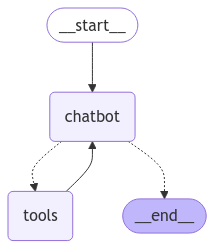

In [7]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [8]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User: What do you know about LangGraph?


ValueError: No message found in input state to tool_edge: {'messages': [HumanMessage(content='What do you know about LangGraph?', additional_kwargs={}, response_metadata={}, id='d2f7aa5f-2912-429f-9e28-81630ceb195c'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_nGlTuOPTsUEQPNiY2AXfpTQl', 'function': {'arguments': '{"query":"LangGraph"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 87, 'total_tokens': 106, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_831e067d82', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-9da9c727-51b3-4444-ac5c-090d01ccfd8d-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'LangGraph'}, 'id': 'call_nGlTuOPTsUEQPNiY2AXfpTQl', 'type': 'tool_call'}], usage_metadata={'input_tokens': 87, 'output_tokens': 19, 'total_tokens': 106, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}